# MNIST Classifier of Hand Written Digits using Keras

Import the necessary dependencies and import the test

In [1]:
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras import backend as K, layers
K.set_image_dim_ordering('th')

# Reduce log level
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

Using TensorFlow backend.


## Keras Sequential Model

Using [Keras Sequential Model](https://keras.io/getting-started/sequential-model-guide/) we can create a linear layer stack. The model needs to know what input shape it should expect. For this reason, we need to specify the input shape.

Here we'll create one linear classifier and one ConvNet classifier

### Linear Classifier

First we need to reshape and normalize the training data to 28x28 images. Meaning that the input vectors length will be same as the pixels i.e. 28x28 = 784.
Also specify the length of the categories i.e. 10 using one-hot encoding (i.e. making the values only ones and zeros e.g. [0,0,0,1,0,0,0,0,0,0] would represent the value 3) since we have images of values from 0-9.

In [6]:
# Fetch the datasets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape tuple to use number of pixels instead
n_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], n_pixels)
X_test = X_test.reshape(X_test.shape[0], n_pixels)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the data from greyscale 0-255 to 0-1
X_train /= 255
X_test /= 255

# Print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

# One-hot encoding
# Convert to binary encoding
n_classes = 10
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Train categories shape", Y_train.shape)


Train matrix shape (60000, 784)
Test matrix shape (10000, 784)
Train categories shape (60000, 10)


#### Compile the Linear Sequential Model

Initialize the linear sequential model

In [7]:
# Initiate the Linear Sequential Model
# Only using defining one output layer corresponds to a linear classifier
linear_model = Sequential([
    Dense(n_classes, input_shape=(n_pixels,)),
    Activation('softmax'),
])

# Compile the model using cross entropy loss
# and Adam (https://arxiv.org/abs/1412.6980v8) gradient-based optimizer
linear_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

#### Training the Linear Stack

Training the model for 15 epochs. The lower the loss, the better.

In [8]:
# Training the model for 15 epochs
linear_model.fit(X_train, Y_train,
          batch_size=128, epochs=15,
          verbose=2,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
 - 1s - loss: 0.6862 - acc: 0.8300 - val_loss: 0.3856 - val_acc: 0.9013
Epoch 2/15
 - 1s - loss: 0.3636 - acc: 0.9021 - val_loss: 0.3201 - val_acc: 0.9137
Epoch 3/15
 - 1s - loss: 0.3203 - acc: 0.9120 - val_loss: 0.2985 - val_acc: 0.9158
Epoch 4/15
 - 1s - loss: 0.3002 - acc: 0.9170 - val_loss: 0.2847 - val_acc: 0.9211
Epoch 5/15
 - 1s - loss: 0.2883 - acc: 0.9199 - val_loss: 0.2786 - val_acc: 0.9241
Epoch 6/15
 - 1s - loss: 0.2800 - acc: 0.9223 - val_loss: 0.2742 - val_acc: 0.9232
Epoch 7/15
 - 1s - loss: 0.2738 - acc: 0.9236 - val_loss: 0.2706 - val_acc: 0.9247
Epoch 8/15
 - 1s - loss: 0.2692 - acc: 0.9251 - val_loss: 0.2690 - val_acc: 0.9253
Epoch 9/15
 - 1s - loss: 0.2652 - acc: 0.9259 - val_loss: 0.2675 - val_acc: 0.9258
Epoch 10/15
 - 1s - loss: 0.2623 - acc: 0.9269 - val_loss: 0.2664 - val_acc: 0.9268
Epoch 11/15
 - 1s - loss: 0.2597 - acc: 0.9275 - val_loss: 0.2645 - val_acc: 0.9253
Epoch 12/15
 - 1s - loss: 0.2572 - 

#### Test & Evaluate


Linear Classifier:
9273  classified correctly
727  classified incorrectly


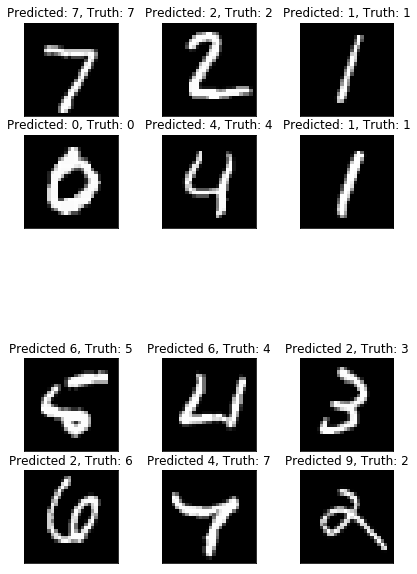

In [9]:
%matplotlib inline

# Get the model predictions on the test set
predicted_classes = linear_model.predict_classes(X_test)

#
# Create arrays using numpy to evaluate the predictions for conv model
#
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print('Linear Classifier:')
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# Set figure image size
plt.rcParams['figure.figsize'] = (7,12)

figure_evaluation = plt.figure()

# Plot 6 correct predictions
for i, correct in enumerate(correct_indices[:6]):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])

# Plot 6 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:6]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

### ConvNet Classifier

For the ConvNet input vector we need to do some other reshaping. To work with Keras API for 2D-convolutions, we need to reshape the image data to 4 dimensions.

In [14]:
# Fetch the datasets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape to 4 dimensions i.e. samples, pixels, width, height
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

# Normalize the data from greyscale 0-255 to 0-1
X_train /= 255
X_test /= 255

# Print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

# One-hot encoding
# Convert to binary encoding
n_classes = 10
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Train categories shape", Y_train.shape)

Train matrix shape (60000, 1, 28, 28)
Test matrix shape (10000, 1, 28, 28)
Train categories shape (60000, 10)


#### Compile the ConvNet Sequential Model

We´re adding two hidden layers, one being the convolutional layer and one fully connected layer.

In [15]:
# Import necessary deps for conv2d
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

# Initiate the ConvNet Sequential Model
conv_model = Sequential()

# Add the first hidden layer - the convolutional layer
conv_model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu')) # the input layer, expecting pixel, width, height
conv_model.add(MaxPooling2D(pool_size=(2, 2))) # pooling layer with size 2X2
conv_model.add(Dropout(0.2)) # Exclude 20% of the layer nodes to reduce overfitting
conv_model.add(Flatten()) # Convert the 2D data to vector

# Add the second fully connected hidden layer
conv_model.add(Dense(128, activation='relu'))

# Add the output layer
conv_model.add(Dense(n_classes, activation='softmax'))

# Compile the model using cross entropy loss
# and Adam (https://arxiv.org/abs/1412.6980v8) gradient-based optimizer
conv_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

#### Training the ConvNet Model


In [ ]:
# Training the model for 10 epochs
conv_model.fit(X_train, Y_train,
          batch_size=200, epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 7200/60000 [==>...........................] - ETA: 2:10 - loss: 0.8131 - acc: 0.7868

#### Test & Evaluate


ConvNet Classifier:
9897  classified correctly
103  classified incorrectly


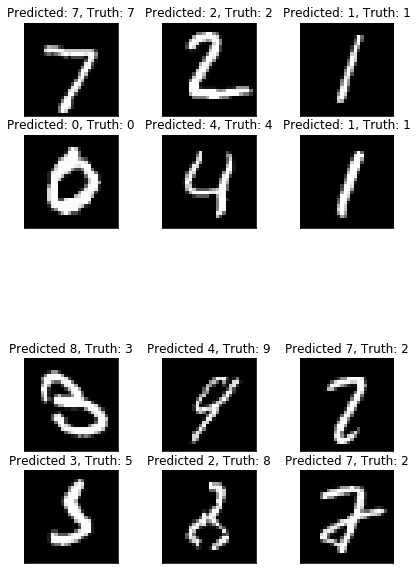

In [190]:
%matplotlib inline

# Get the model predictions on the test set
predicted_classes = conv_model.predict_classes(X_test)

#
# Create arrays using numpy to evaluate the predictions for conv model
#
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print('ConvNet Classifier:')
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# Set figure image size
plt.rcParams['figure.figsize'] = (7,12)

figure_evaluation = plt.figure()

# Plot 6 correct predictions
for i, correct in enumerate(correct_indices[:6]):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])

# Plot 6 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:6]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])